In [55]:
# basics
import pandas as pd
import numpy as np

# matplotlib
import matplotlib.pyplot as plt


from funcs.rotation import (get_period_get_amplitude, 
                            rotation_period_uncertainties_mcmc)

# data management
import time as Timestamp
tstamp = Timestamp.strftime("%d_%m_%Y", Timestamp.localtime())

import os
CWD = "/".join(os.getcwd().split("/")[:-2])

import lightkurve as lk


import matplotlib 
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

font = {'family' : 'courier',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

from matplotlib.lines import Line2D

In [166]:
from funcs.detrend import custom_detrending, estimate_detrended_noise
from altaipony.flarelc import FlareLightCurve

from altaipony.utils import sigma_clip


def plot_phase_folded_lightcurve(ax, row):
    
    nlcs = {"277" : 1, "449": 3, "237" : 2, "452":3}
    x = str(row.ID)[:3]

    res = lk.search_lightcurvefile(f"TIC {row.ID:.0f}")[:nlcs[x]]
    
    sectors = list(res.table["sequence_number"].data.data.astype(str))
    if len(sectors) > 1:
        plural = "s"
    s = ", ".join(sectors)

    flcs = res.download_all()

    FLC = flcs.PDCSAP_FLUX.stitch()


    # define FlareLightCurve for flare search and masking
    FLC = FlareLightCurve(time=FLC.time, flux=FLC.flux, flux_err=FLC.flux_err, campaign=FLC.sector)

    FLC = FLC[(np.isfinite(FLC.time)) & (np.isfinite(FLC.flux)) & (np.isfinite(FLC.flux_err))]

    # detrend light curve
    FLCd = custom_detrending(FLC)

    # mask outliers
    mask = sigma_clip(FLCd.detrended_flux)

    # mask flare
    FLC.flux[(FLC.time > 1331.2) & (FLC.time < 1332.6)] = np.nan
    FLC.flux[(FLC.time > 1641.3) & (FLC.time < 1642.6)] = np.nan
    FLC.flux[(FLC.time > 1493.7) & (FLC.time < 1494.5)] = np.nan


    # Mask the flares:
    FLC.flux[~mask] = np.nan

    # fold the masked lightcurve with previously derived rotation period
    folded = FLC.fold(period=row.Prot_d, t0=FLC.time[0], )


    # plot folded lightcurve
    ax.scatter(folded.time, folded.flux / np.nanmedian(folded.flux), 

               c="grey", alpha=.2,s=5 )

    t = folded.time
    p = pd.Series(folded.flux).rolling(800, min_periods=400, center=True).median().values / np.nanmedian(folded.flux)

    ax.plot(t, p, c="k", linewidth=3)
    
    

    legend_elements = [Line2D([0], [0], marker='o', color='w', 
                       label=f"TIC {row.ID:.0f}" +
                             r" ($P_{rot}=$ " + 
                             f"{row.Prot_d*24.:.2f} h) \nphase folded light curve \n(Sector{plural} {s})",
                       markerfacecolor='grey', markersize=8),
                       Line2D([0], [0], color='k', lw=3, label="rolling median"),
                      ]

    ax.legend(handles=legend_elements, fontsize=14, frameon=False, loc=1)

In [167]:
rot = pd.read_csv(f"{CWD}/analysis/results/mcmc/rotation/mcmc_rotation_output_propagated.csv")

In [168]:
row = rot.iloc[0]

In [169]:
rot

,ID,Prot_d,e_Prot_d
0,44984200,0.112982,0.000005
1,237880881,0.351489,0.000021
2,277539431,0.190013,0.000014
3,452922110,0.176417,0.000037


In [164]:
res = lk.search_lightcurvefile(f"TIC {row.ID:.0f}")

In [165]:
sectors = list(res.table["sequence_number"].data.data.astype(str))
if len(sectors) > 1:
    plural = "s"
s = ", ".join(sectors)


'8, 9, 10, 35, 35'

In [ ]:


%matplotlib inline
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,12), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0, wspace=0)

In [133]:

for i, ax in enumerate(axes):
    
    plot_phase_folded_lightcurve(ax, row)


plt.ylim(.92,1.08)
plt.xlim(-0.5,0.5)
for i in [0,2]:
    axes[i].set_ylabel(r"Normalized flux",fontsize=15)

axes[-1].set_xlabel(f"Phase",fontsize=15)
plt.savefig(f"../plots/rotation/{row.ID:.0f}_phase_curve_total.png", dpi=300)

Found cached file /home/ekaterina/.lightkurve-cache/mastDownload/TESS/tess2019140104343-s0012-0000000277539431-0144-s/tess2019140104343-s0012-0000000277539431-0144-s_lc.fits with expected size 2041920.
5% (1015/20119) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (1015/20119) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


In [137]:
flcs = [FLC[:9000],FLC[9000:]]

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/ipykernel_launcher.py:1: ResourceWarning: unclosed file <_io.FileIO name='/home/ekaterina/.lightkurve-cache/mastDownload/TESS/tess2019140104343-s0012-0000000277539431-0144-s/tess2019140104343-s0012-0000000277539431-0144-s_lc.fits' mode='rb' closefd=True>
  """Entry point for launching an IPython kernel.


0.002976999999987129 1.1362980000000107 0.1408720000000585 0.13689899999997124 0.06931499999996049 0.07280000000002929 1.5591610000000173


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.007892000000083499 0.9318829999999707 0.13644799999997304 0.1357629999999972 0.13385600000003706 0.07725399999992533 1.4230959999999868


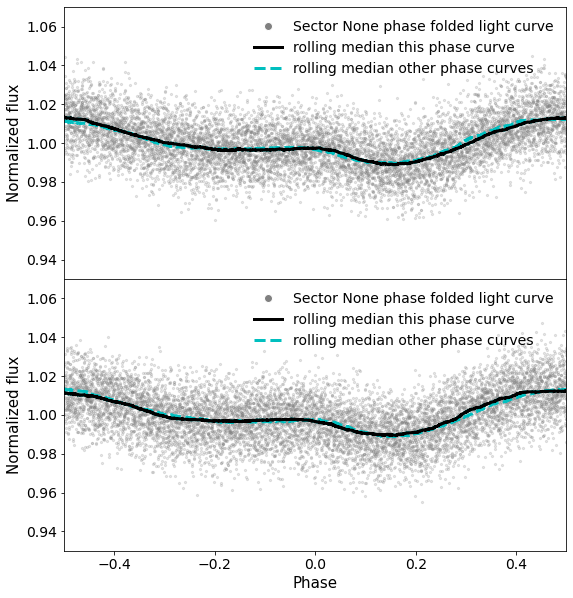

In [138]:
%matplotlib inline
fig, axes = plt.subplots(nrows=len(flcs), ncols=1, figsize=(9,len(flcs)*5), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0)


means=[]
# colors = ["black", "grey", "blue",]
for ax, flc in list(zip(axes, flcs)):
    
    # get PDC treated light curve
    #flc = flc.get_lightcurve("PDCSAP_FLUX")
    
    # define FlareLightCurve for flare search and masking
    flc = FlareLightCurve(time=flc.time, flux=flc.flux, flux_err=flc.flux_err, campaign=flc.sector)
    
    flc = flc[(np.isfinite(flc.time)) & (np.isfinite(flc.flux)) & (np.isfinite(flc.flux_err))]

    # detrend light curve
    flcd = custom_detrending(flc)

    # mask outliers
    mask = sigma_clip(flcd.detrended_flux)
    
    # mask flare
    flc.flux[(flc.time > 1331.2) & (flc.time < 1332.6)] = np.nan
    
    # Mask the flares:
    flc.flux[~mask] = np.nan
    
    # fold the masked lightcurve with previously derived rotation period
    folded = flc.fold(period=row.Prot_d, t0=flcs[0].time[0], )
    
    # 
    means.append((folded.time, 
                 pd.Series(folded.flux).rolling(800, min_periods=400, center=True).median() /
                  np.nanmedian(folded.flux)))
    
    # plot folded lightcurve
    ax.scatter(folded.time, folded.flux / np.nanmedian(folded.flux), 
              
               c="grey", alpha=.2,s=5 )
    
    ax.set_ylabel(r"Normalized flux",fontsize=15)
    
    
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=f"Sector {flc.campaign} phase folded light curve",
                          markerfacecolor='grey', markersize=8),
                         Line2D([0], [0], color='k', lw=3, label="rolling median this phase curve"),
                    Line2D([0], [0], color='c', lw=3, linestyle="dashed", label="rolling median other phase curves"),
                 
                   ]

    ax.legend(handles=legend_elements, fontsize=14, frameon=False, loc=1)
    
for i, k in enumerate(list(zip(axes, means))):
    ax, mean = k
    for time, flux in means:
        ax.plot(time, flux, c="c", linewidth=3, linestyle="dashed")
    ax.plot(mean[0], mean[1], c="k", linewidth=3)
    

    
plt.ylim(.93,1.07)
plt.xlim(-0.5,0.5)

axes[-1].set_xlabel(f"Phase",fontsize=15)

plt.savefig(f"../plots/rotation/{row.ID:.0f}_phase_curve_total_split.png", dpi=300)

# Backlog

In [29]:
flcd = estimate_detrended_noise(flcd)

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [35]:
uncertainty = (flcd.detrended_flux_err / flcd.detrended_flux).mean()

In [36]:
uncertainty * 2

0.015485069106868357

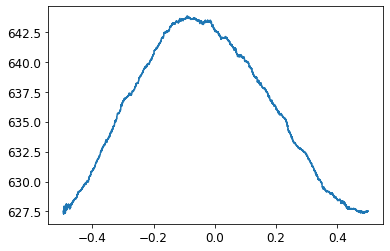

In [42]:
plt.plot(folded.time, pd.Series(folded.flux).rolling(800, min_periods=100).median())